# Final Workflow Classification with Keras

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.client import device_lib
from tensorflow.keras import layers
from tensorflow import keras
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import numpy as np
import os

## Preparing Datasets and Preprocessing

Divide information in images by 255 to have smaller values for faster computation.

In [2]:
train = ImageDataGenerator(rescale= 1./255)
test = ImageDataGenerator(rescale=1./255)
validation = ImageDataGenerator(rescale=1./255)

Import Datasets that are already prepared in file systems (train, test, validation) that depict classification (IO, NIO).

Within this step, the images are preprocessed and the batch_size is defined. 

<b>IMPORTANT! </b> the same prepocessing needs to happen to the images before inference.

In [3]:
path_train_dataset = ''
path_validation_dataset  = ''
path_test_dataset = ''

classmode = 'categorical'
targetsize = (224,224)
batchsize = 32
colormode = 'rgb'

In [4]:
train_dataset = train.flow_from_directory(
                                          directory = path_train_dataset,
                                          target_size = targetsize,
                                          batch_size = batchsize,
                                          class_mode = classmode,
                                          color_mode = colormode)

validation_dataset = validation.flow_from_directory(
                                                    directory = path_validation_dataset,
                                                    target_size = targetsize,
                                                    batch_size = batchsize,
                                                    class_mode = classmode,
                                                    color_mode = colormode)

test_dataset = test.flow_from_directory(
                                        directory = path_test_dataset,
                                        target_size = targetsize,
                                        batch_size = batchsize,
                                        class_mode = classmode,
                                        color_mode = colormode)

FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: 'D:\\Datensatz-DeepLearning-Augmented-AfterSplit\\train'

Display Classification labels and their indices that were deduced from the filesystem

In [96]:
print(train_dataset.class_indices)

{'IO': 0, 'NIO': 1}


## Display Example Images and their Shape

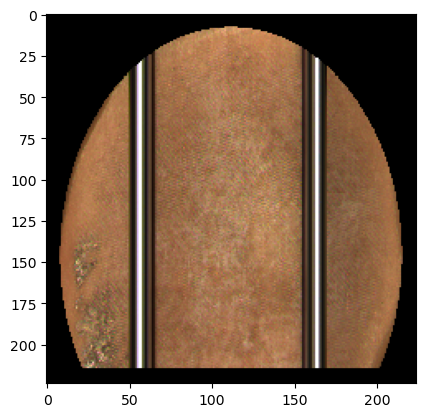

Shape: (224, 224, 3)
Width: 224
Height: 224
Channels: 3


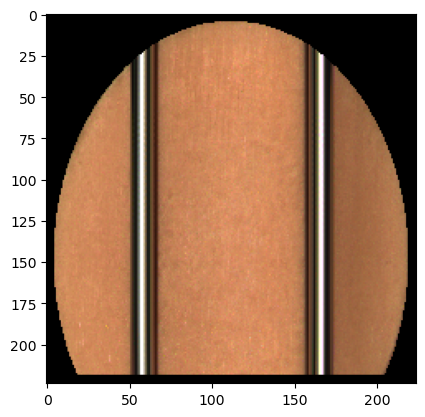

Shape: (224, 224, 3)
Width: 224
Height: 224
Channels: 3


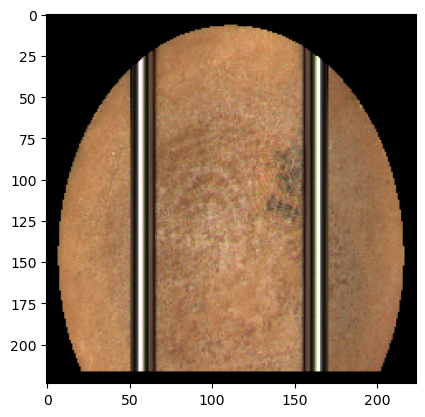

Shape: (224, 224, 3)
Width: 224
Height: 224
Channels: 3


In [97]:
for _ in range(3):
    img, label = test_dataset.next()

    plt.imshow(img[0])
    plt.show()
    shape = img[0].shape
    
    print('Shape:',shape)
    print('Width:',shape[0])
    print('Height:',shape[1])
    print('Channels:',shape[2])

## Verify rescaling

In [98]:
print("Verify that pixels are in the [0,1] range.")
print("Min and max pixel values:","min:",img[0].min(),", max:",img[0].max())

Verify that pixels are in the [0,1] range.
Min and max pixel values: min: 0.0 , max: 1.0


# Data Augmentation

Below, the types of data augmentations for the datasets are shown. The current Dataset has already been augmented. Augmentation can also happen in the model, which is more memory efficient.

In [99]:
# Function to visualize original and augmented images next to each other

def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

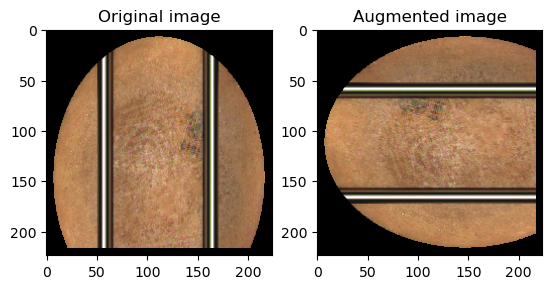

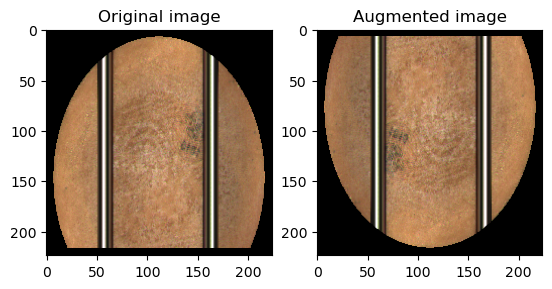

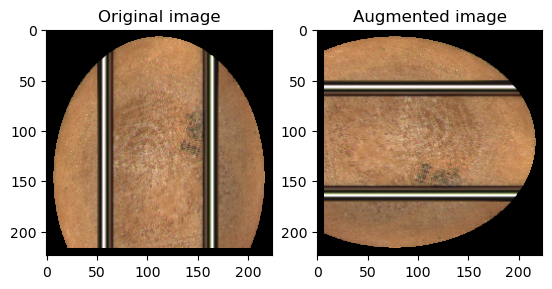

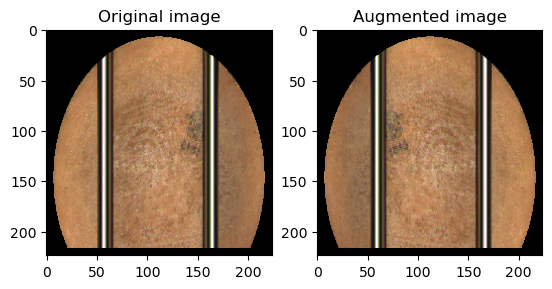

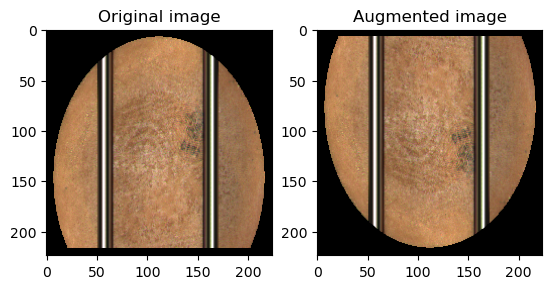

In [100]:
rotated = tf.image.rot90(img[0])
visualize(img[0], rotated)

rotated2 = tf.image.rot90(rotated)
visualize(img[0], rotated2)

rotated3 = tf.image.rot90(rotated2)
visualize(img[0], rotated3)

flipped_h = tf.image.flip_left_right(img[0])
visualize(img[0], flipped_h)

flipped_v = tf.image.flip_up_down(img[0])
visualize(img[0], flipped_v)

## Set up GPU support for training

Get list of available devices

In [101]:
listOfDevices = device_lib.list_local_devices()

In [102]:
for device in listOfDevices:
    print(device)

name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5940682285776510809

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6024388608
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8545978713833998766
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"



In [103]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [104]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

## Model Creation

In [7]:
inputs = keras.Input(shape=(224, 224, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs, outputs, name="test_resnet")

In [8]:
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [7]:
model.summary()

Model: "test_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 222, 222, 32) 896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 220, 220, 64) 18496       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 73, 73, 64)   0           conv2d_1[0][0]                   
________________________________________________________________________________________

In [17]:
from keras.utils.vis_utils import plot_model

In [15]:
import visualkeras

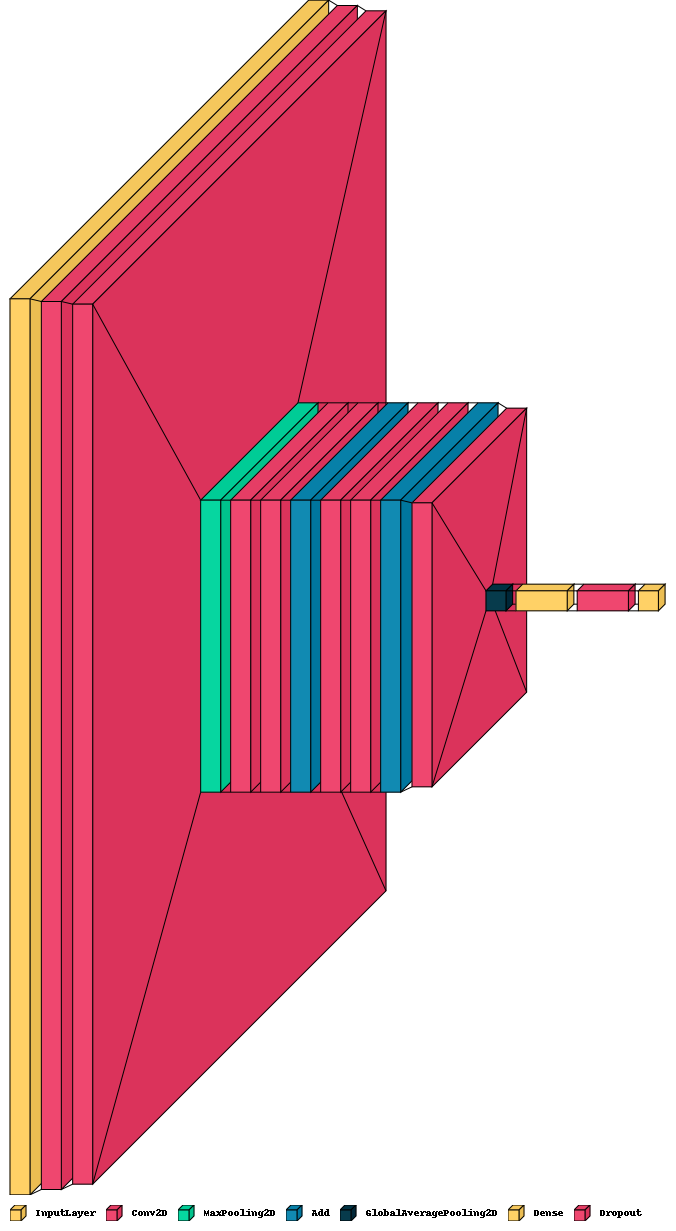

In [9]:
visualkeras.layered_view(model,legend=True, draw_volume=True)

## Modelfit & Training

Training epochs are set to 1 to reduce training time for debugging the forkflow, Model does not work at the moment due to a problem with the channels of the tiff.

In [15]:
model_fit = model.fit(
                      train_dataset,
                      epochs = 30,
                      validation_data = validation_dataset)

Epoch 1/30
204/204 [==============================] - 28s 115ms/step - loss: 0.5990 - accuracy: 0.6491 - val_loss: 0.2758 - val_accuracy: 0.8727
Epoch 2/30
204/204 [==============================] - 23s 112ms/step - loss: 0.4760 - accuracy: 0.7744 - val_loss: 0.1743 - val_accuracy: 0.9447
Epoch 3/30
204/204 [==============================] - 23s 111ms/step - loss: 0.4088 - accuracy: 0.8213 - val_loss: 0.1572 - val_accuracy: 0.9531
Epoch 4/30
204/204 [==============================] - 23s 111ms/step - loss: 0.3515 - accuracy: 0.8485 - val_loss: 0.1397 - val_accuracy: 0.9564
Epoch 5/30
204/204 [==============================] - 23s 112ms/step - loss: 0.3138 - accuracy: 0.8682 - val_loss: 0.2542 - val_accuracy: 0.9062
Epoch 6/30
204/204 [==============================] - 23s 111ms/step - loss: 0.2264 - accuracy: 0.9113 - val_loss: 0.2901 - val_accuracy: 0.8911
Epoch 7/30
204/204 [==============================] - 23s 111ms/step - loss: 0.1803 - accuracy: 0.9272 - val_loss: 0.1561 - val_ac

## Model Evaluation

In [16]:
score = model.evaluate(test_dataset, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

19/19 [==============================] - 5s 238ms/step - loss: 0.0643 - accuracy: 0.9833
Test loss: 0.06430526077747345
Test accuracy: 0.9833333492279053


## Inference Testdata

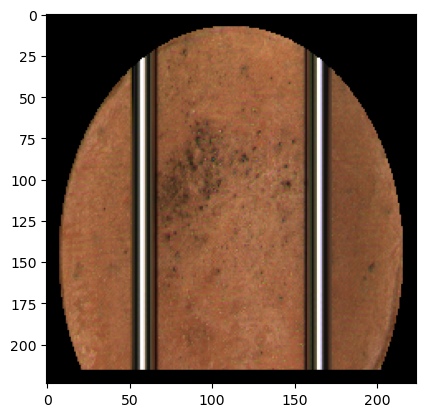

This Cheese is 0.02301% IO and  99.97699% NIO.


In [105]:
image_path = 'D:\\Datensatz-DeepLearning-Augmented-AfterSplit\\test\\NIO\\20211219_005715.tif'
img_size = (224, 224)

img = tf.keras.preprocessing.image.load_img(
                                            path=image_path,                                           
                                            target_size=targetsize,
                                            color_mode=colormode)
plt.imshow(img)
plt.show()

X = tf.keras.utils.img_to_array(img)
X = X/255.
X = np.expand_dims(X,axis = 0)
images = np.vstack([X])

predictions = model.predict(images)

score = float(predictions[0][0])
print(f"This Cheese is {100 * score:.5f}% IO and  {100 * (1 - score):.5f}% NIO.")

## Grad CAM

In [106]:
last_conv_layer_name = "conv2d_6"

In [107]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

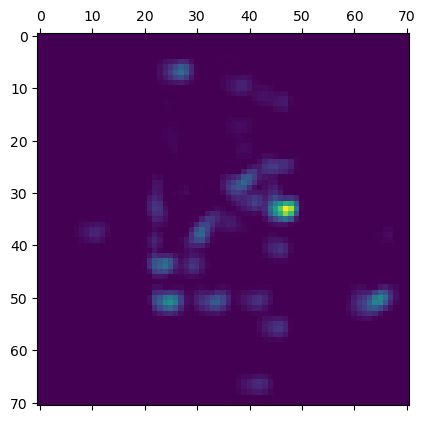

This Cheese is 0.02301% IO and  99.97699% NIO.


In [110]:
# Prepare image
img_array = keras.preprocessing.image.img_to_array(img)
img_array = img_array/255.
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

score = float(preds[0][0])
print(f"This Cheese is {100 * score:.5f}% IO and  {100 * (1 - score):.5f}% NIO.")

In [74]:
# Display
from IPython.display import Image, display

In [75]:
def save_and_display_gradcam(img_path, heatmap, cam_path='cam.jpg', alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

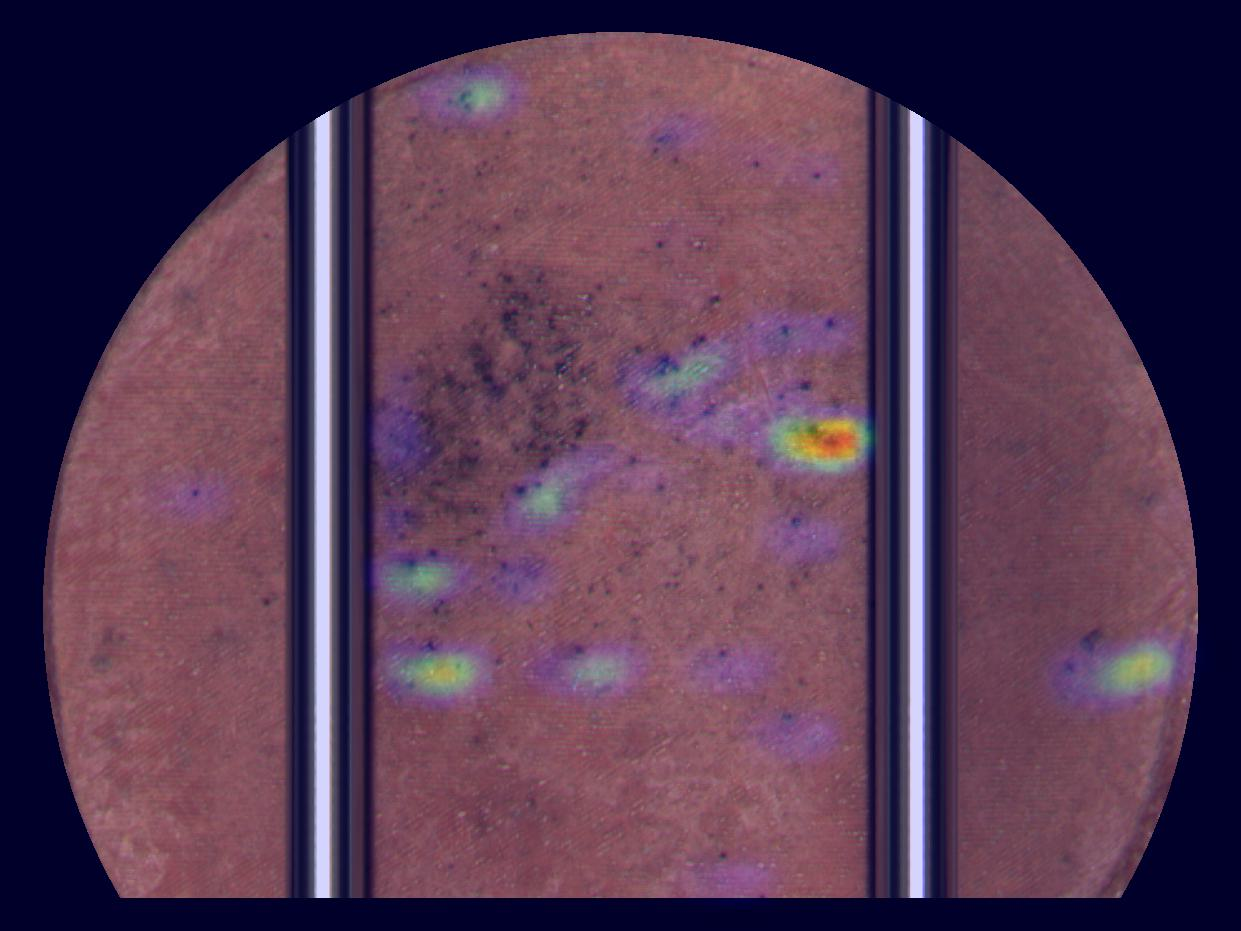

In [76]:
save_and_display_gradcam(image_path, heatmap)

## Save Keras Model

In [19]:
model.save('')